**Байесовский классификатор: метод парзеновского окна**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##  загружаем данные 

In [2]:
from sklearn.datasets import make_blobs

n_samples = 500
n_cls = 2

X,y = make_blobs( 
        n_samples=n_samples,
        centers=n_cls,  
        cluster_std=[1.0, 2.5,]
    )


lmbd = [ 1.1, ]*n_cls  # коэффициент "цены" ошибки

X.shape, y.shape

((500, 2), (500,))

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, )

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((250, 2), (250,), (250, 2), (250,))

In [4]:
%xdel X
%xdel y

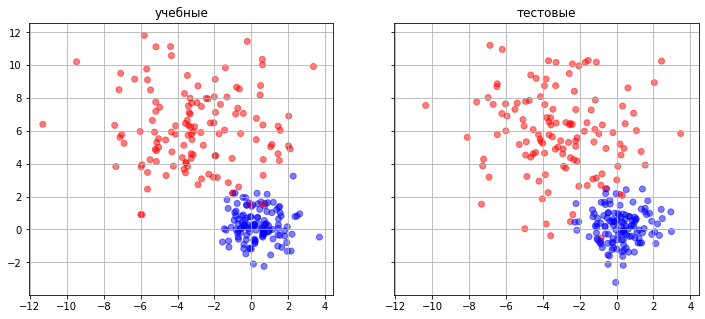

In [5]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

##  строим классификатор

In [6]:
# ядро Епанечникова
def K(x): return (1.0 - x**2) * 0.75

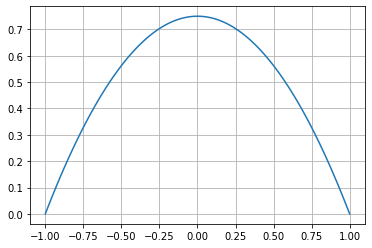

In [7]:
x = np.linspace(-1,1,100)
plt.plot(x,K(x))
plt.grid()
plt.show()

In [8]:
# евклидова метрика
def rho(x1,x2): return np.sqrt( np.square(x1-x2).sum(axis=1) )

$ 
a(x) = \underset{y\in Y}{\operatorname{argmax}} 
\left[ \lambda_y P_y \frac{1}{l_y} \underset{i:y=y_i}{\sum} K\left(\frac{\rho(x-x_i)}{h}\right) \right] 
$

In [9]:
def bayes_score(X,Xl,yl,lmbd_n,h,n,Py_n,ly_n): # скор принадлежности X к классу n
    # Xl,yl - учебный набор
    # Py_n - априорная вероятность класса n
    # ly_n - количество объектов в классе n
    # lmbd_n - цена ошибки класса n
    # h - ширина парзеновского окна
    
    Xn = Xl[yl==n,:] # точки класса n

    # для каждой точки набора X
    # считаем растояние до всех точек учебного класса
    r = np.asarray([ rho(X[i,:],Xn) for i in range(X.shape[0]) ]) 
    
    # применяем ядро и суммируем
    r = K( r / h).sum(axis=1)

    return ( Py_n * lmbd_n / ly_n ) * r


In [10]:
def bayes(X,Xl,yl,lmbd,h): # байесовский классификатор
    # для кажной точки набора X 
    # хаходим номер класса с наибольшим скором
    # Xl,yl - учебный набор
    # lmbd - цена ошибки классов    
    # h - ширина окна
    
    # количество объектов в классах
    ly = np.asarray([ (yl==c).sum() for c in sorted(set(yl)) ])
    Py = ly/ly.sum() # априорные вероятности классов
    
    return np.argmax( 
        np.asarray([ 
            bayes_score(X,Xl,yl,lmbd[n],h,n,Py[n],ly[n])  
            for n in sorted(set(yl)) 
        ]),
        axis=0 )

### выбор ширины парзеновского окна

In [11]:
# LOO ( leave one out) - скользящий контроль,
# выбираем объект учебного набора X,y
# удаляем его из набора
# выполняем его классификацию и проверяем ответ
def loo(X,y,lmbd,h):
    er = 0 # количество ошибок
    for i in range(X.shape[0]):
        xi,yi = X[i,:].reshape(1,X.shape[1]),y[i] # выбираем объект учебного набора
        # удаляем его из набора
        Xl,yl = np.delete(X, i, axis=0), np.delete(y, i, axis=0)
        er += int(bayes(xi,Xl,yl,lmbd,h) != yi) # выполняем классификацию и проверяем ответ

    return er

In [12]:
# подбираем параметр ширины парзеновского окна 
er = { loo(X_train,y_train,lmbd,h) : h   for h in range(5,0,-1) }
h = er[min(er)]

In [13]:
er

{21: 1}

In [14]:
h

1

##  результаты

In [15]:
o = bayes(X_test,X_train,y_train,lmbd,h)

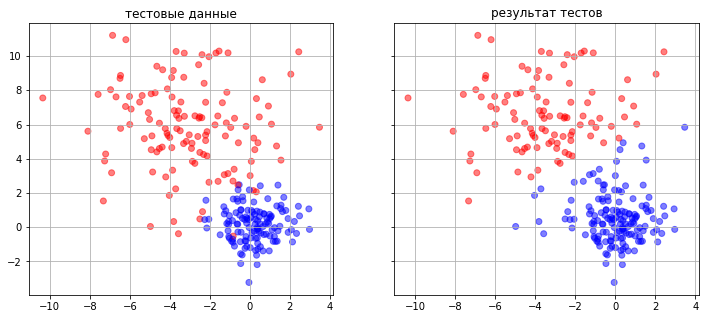

In [16]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y_test,'тестовые данные')    
plot_data(ax1,X_test,o,'результат тестов')    
plt.show()

## метрики качества

In [17]:
from sklearn.metrics import classification_report
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       126
           1       1.00      0.81      0.89       124

    accuracy                           0.90       250
   macro avg       0.92      0.90      0.90       250
weighted avg       0.92      0.90      0.90       250



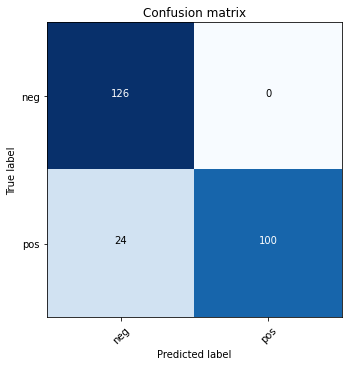

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_test,o)

classes = ['neg','pos']  if n_cls<3 else list(range(n_cls))
tick_marks = np.arange(len(classes))

plt.figure(figsize=(5,5))


plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')

# # plt.colorbar()

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

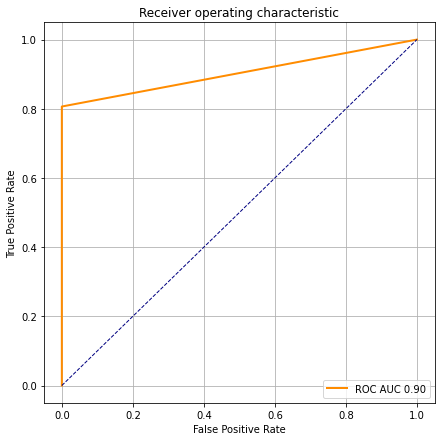

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


if n_cls<3:
    fpr, tpr, thresholds = roc_curve( y_test, o )
    roc_auc = auc(fpr,tpr)

    plt.figure(figsize=(7,7))
    plt.grid(True)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## карта скоров

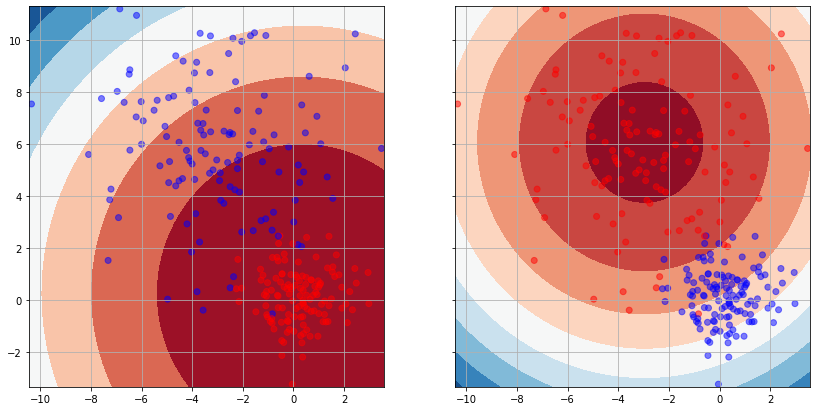

In [20]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки


xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 

# количество объектов в классах
ly = np.asarray([ (y_train==c).sum() for c in sorted(set(y_train)) ])
Py = ly/ly.sum() # априорные вероятности классов

pp = [ 
        bayes_score(xy,X_train,y_train,lmbd[n],h,n,Py[n],ly[n])  
        for n in sorted(set(y_train)) 
    ]


n_cls=len(set(y_train))
ph=7
pw=ph*n_cls

f, axarr = plt.subplots(1,n_cls, sharey=True, sharex=True, figsize=(pw,ph),)
    
for c in sorted(set(y_train)):     
    clr = [ ['b','r'][ int(j==c) ] for j in y_test  ]
    axarr[c].contourf(xx, yy, 1.0-pp[c].reshape(n,n), cmap=plt.cm.RdBu)
    axarr[c].scatter( x=X_test[:,0], y=X_test[:,1], c=clr, alpha=.5 )
    axarr[c].grid()

plt.show()